In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q "/content/gdrive/My Drive/COVID-19 Dataset.zip"

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
INIT_LR = 1e-3

EPOCHS = 10

BS = 8

dataset = "/content/COVID-19 Dataset"

In [ ]:
args={}
args["dataset"]=dataset

args

{'dataset': '/content/COVID-19 Dataset'}

In [ ]:
import numpy as np
import cv2
iPaths = list(paths.list_images(args["dataset"]))  #image paths
data = []
labels = []
for iPath in iPaths:
    label = iPath.split(os.path.sep)[-2]   #split the image paths
    image = cv2.imread(iPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert images into RGB Channel
    image = cv2.resize(image, (224, 224))  #Resizing the images
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
image.shape

(224, 224, 3)

In [ ]:
import os
Data_Dir = "COVID-19 Dataset//"

In [ ]:
Cimages = os.listdir(Data_Dir+"COVID-19")
Nimages = os.listdir(Data_Dir+"NORMAL")

Normal Chest X-ray Vs Covid-19 Chest X-ray


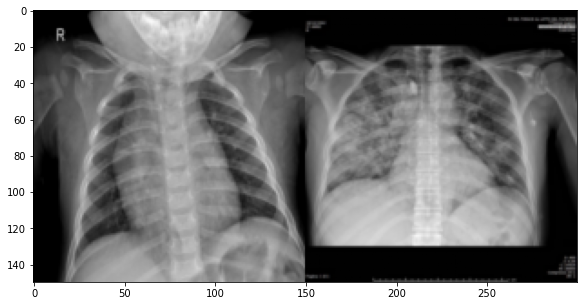

Normal Chest X-ray Vs Covid-19 Chest X-ray


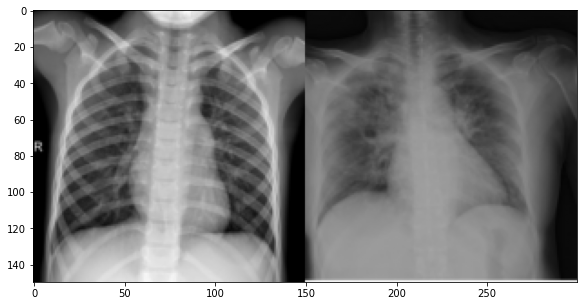

Normal Chest X-ray Vs Covid-19 Chest X-ray


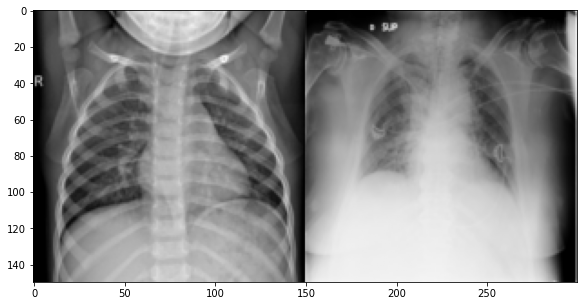

Normal Chest X-ray Vs Covid-19 Chest X-ray


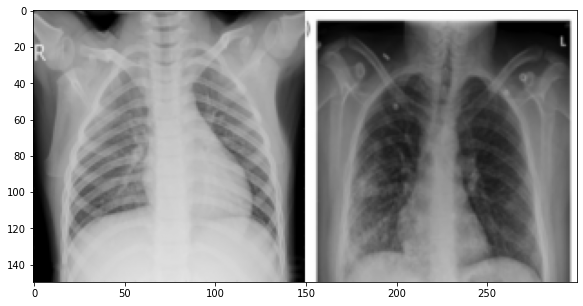

Normal Chest X-ray Vs Covid-19 Chest X-ray


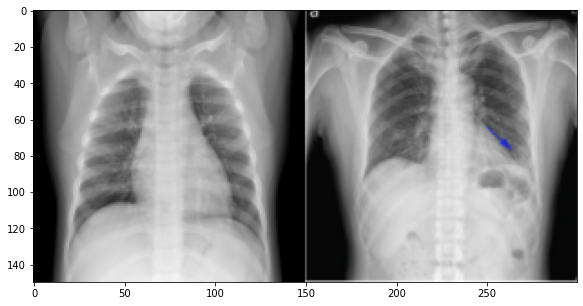

In [ ]:
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize
import numpy as np
def plotter(i):
    normal = cv2.imread(Data_Dir+"NORMAL//"+Nimages[i])
    normal = skimage.transform.resize(normal, (150, 150, 3))
    coronavirus = cv2.imread(Data_Dir+"COVID-19//"+Cimages[i])
    coronavirus = skimage.transform.resize(coronavirus, (150, 150, 3) , mode = 'reflect')
    pair = np.concatenate((normal, coronavirus), axis=1)
    print("Normal Chest X-ray Vs Covid-19 Chest X-ray")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [ ]:
LB = LabelBinarizer()  #Initialize label binarizer
labels = LB.fit_transform(labels)
labels = to_categorical(labels); print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [ ]:
bModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))  #base_Model
hModel = bModel.output #head_Model
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)
for layer in bModel.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape 

((1248, 224, 224, 3), (312, 224, 224, 3), (1248, 2), (312, 2))

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


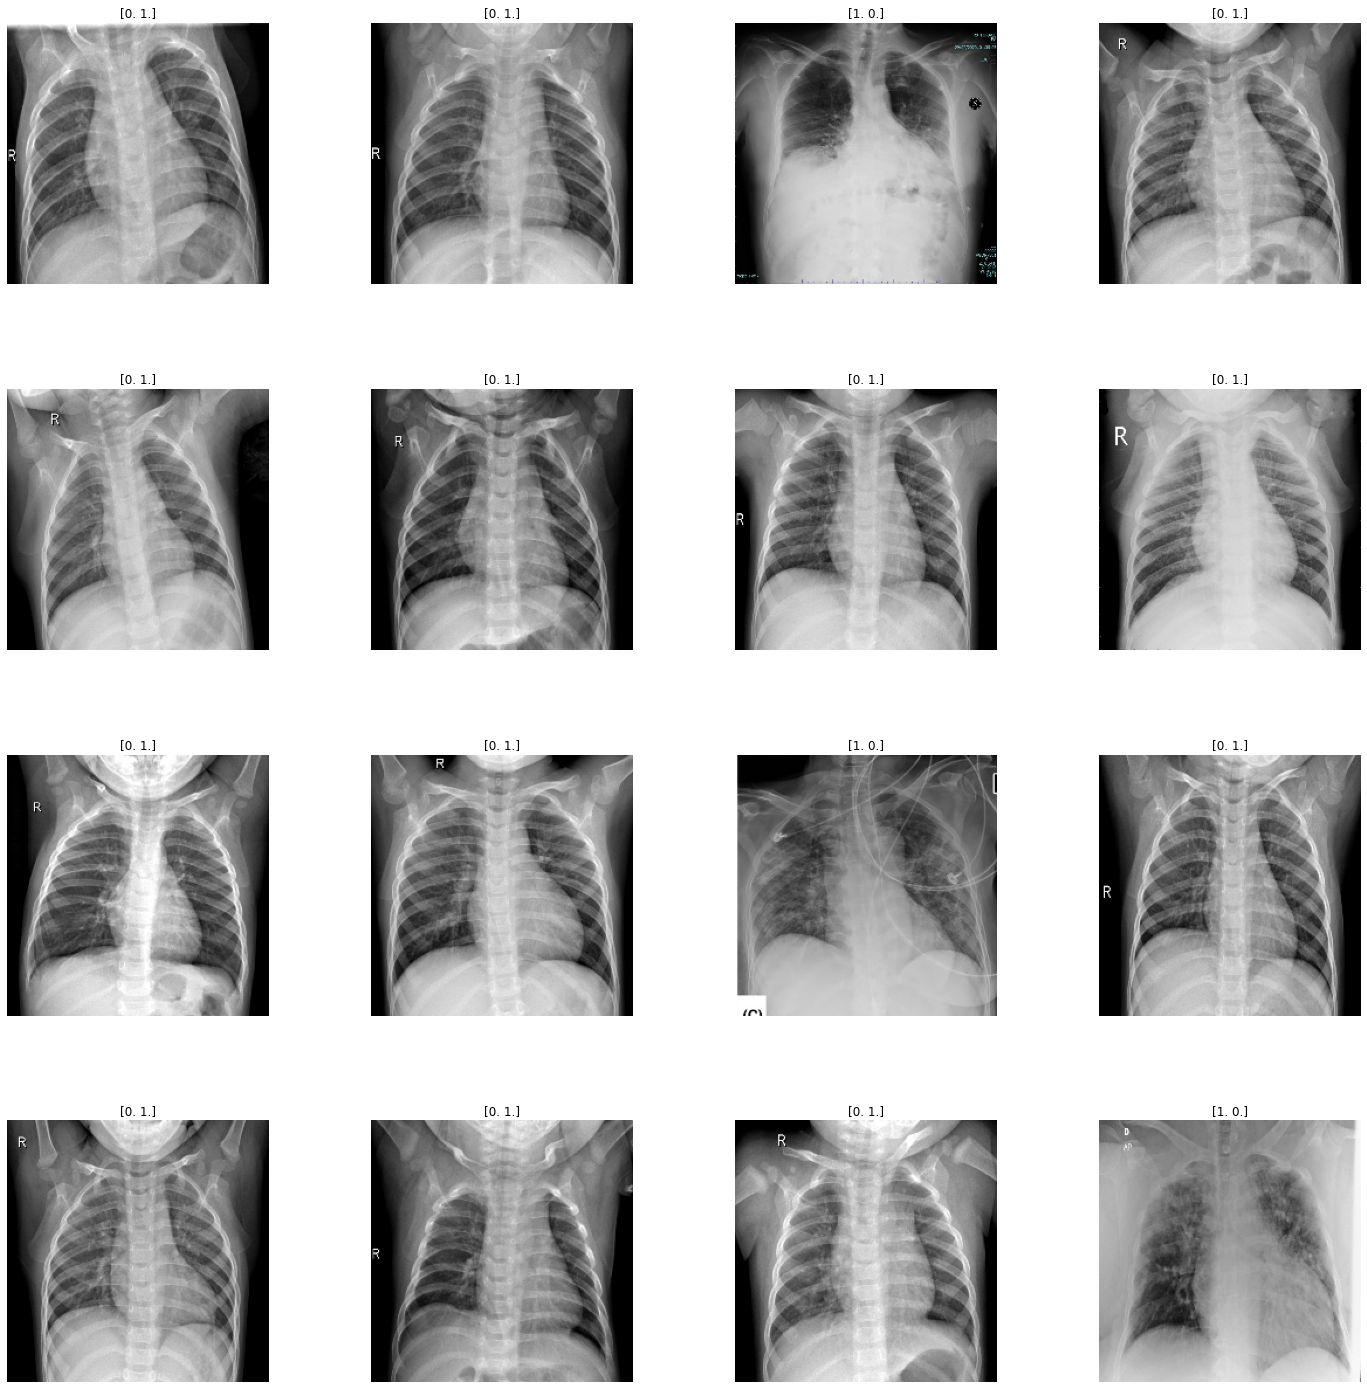

In [ ]:
W_grid = 4 #width
L_grid = 4 #lenth
fig, axes = plt.subplots(L_grid, W_grid, figsize = (25, 25)) #subplots
axes = axes.ravel()
n_training = len(X_train)
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index])
    axes[i].set_title(Y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Compiling Starts")
R = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Compiling Starts
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
156/156 [==============================] - 235s 2s/step - loss: 0.4379 - accuracy: 0.8574 - val_loss: 0.3877 - val_accuracy: 0.8590
Epoch 2/10
156/156 [==============================] - 234s 1s/step - loss: 0.3938 - accuracy: 0.8598 - val_loss: 0.3594 - val_accuracy: 0.8590
Epoch 3/10
156/156 [==============================] - 236s 2s/step - loss: 0.3660 - accuracy: 0.8598 - val_loss: 0.3149 - val_accuracy: 0.8590
Epoch 4/10
156/156 [==============================] - 235s 2s/step - loss: 0.3341 - accuracy: 0.8598 - val_loss: 0.2873 - val_accuracy: 0.8590
Epoch 5/10
156/156 [==============================] - 234s 1s/step - loss: 0.2991 - accuracy: 0.8598 - val_loss: 0.2385 - val_accuracy: 0.8590
Epoch 6/10
156/156 [==============================] - 234s 2s/step - loss: 0.2552 - accuracy: 0.8598 - val_loss: 0.2194 - val_accuracy: 0.8590
Epoch 7/10
156/156 [=============================

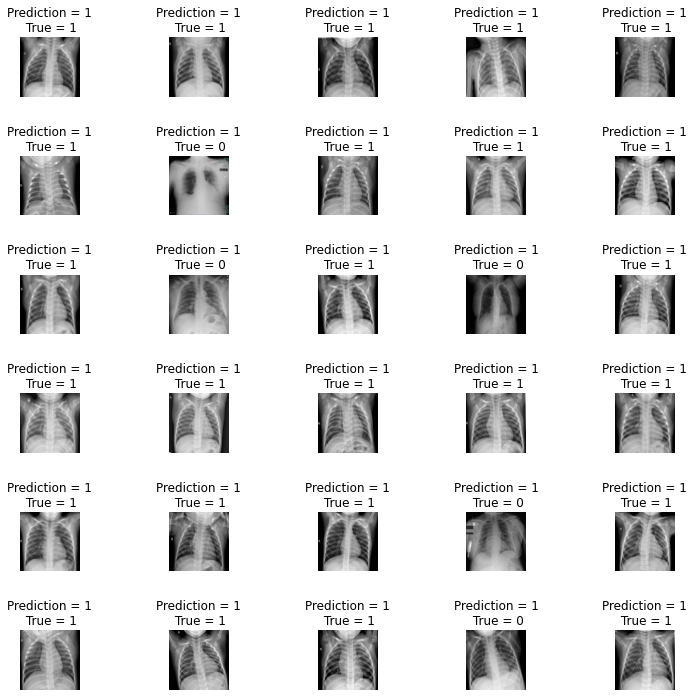

In [ ]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

              precision    recall  f1-score   support

    COVID-19       1.00      0.05      0.09        44
      NORMAL       0.86      1.00      0.93       268

    accuracy                           0.87       312
   macro avg       0.93      0.52      0.51       312
weighted avg       0.88      0.87      0.81       312



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.argmax(axis=1),y_pred)

0.8653846153846154

[[  2  42]
 [  0 268]]
acc: 0.8654
sensitivity: 0.0455
specificity: 1.0000


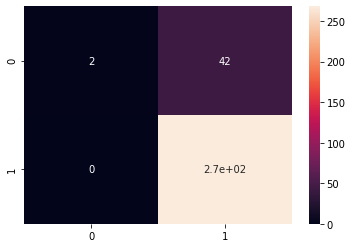

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
sns.heatmap(cm, annot=True, linecolor='white')

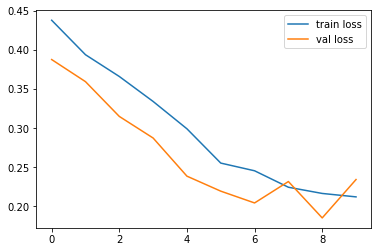

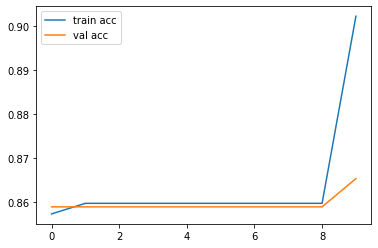

In [ ]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()